## Tugas Besar 2 IF3270 Pembelajaran Mesin - Bagian CNN

Notebook ini akan mengimplementasikan dan mengevaluasi Convolutional Neural Networks (CNN)
untuk klasifikasi gambar pada dataset CIFAR-10.

### **Tujuan Utama:**
1. Melatih model CNN menggunakan Keras dan dataset CIFAR-10, memenuhi ketentuan spesifik.
2. Melakukan analisis pengaruh berbagai hyperparameter terhadap kinerja CNN.
3. Mengimplementasikan modul forward propagation CNN from scratch secara modular.
4. Memvalidasi implementasi from scratch dengan membandingkan hasilnya (macro f1-score) dengan output Keras pada data test.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import time
import os
import sys

In [7]:
!git clone https://github.com/rendangmunir/src

fatal: destination path 'src' already exists and is not an empty directory.


In [8]:
# current_notebook_path = os.getcwd()
# project_root_path = os.path.abspath(
#     os.path.join(current_notebook_path, os.pardir))
# src_path = os.path.join(project_root_path, 'src')

# if src_path not in sys.path:
#     sys.path.insert(0, src_path)
#     print(f"Direktori '{src_path}' telah ditambahkan ke sys.path")
# else:
#     print(f"Direktori '{src_path}' sudah ada di sys.path")
import sys
import os
print(os.getcwd())
print(os.listdir('/content/src'))
sys.path.insert(0, '/content/src')

/content
['CNN', '.git', '__pycache__', 'data_loader.py', 'utils.py', 'models_from_scratch', 'keras_models', '.ipynb_checkpoints']


In [9]:
!ls /src

ls: cannot access '/src': No such file or directory


In [10]:
from data_loader import DataLoaderCIFAR10
from keras_models import cnn_keras_model

In [11]:
from CNN.conv_layer import Conv2DLayerFS
from CNN.activation_layer import ReLULayerFS
from CNN.pooling_layer import MaxPooling2DLayerFS, AveragePooling2DLayerFS
from CNN.flatten_layer import FlattenLayerFS
from CNN.dense_layer import DenseLayerFS

In [12]:
try:
    # Dari src/models_from_scratch/cnn_fs.py
    from models_from_scratch.cnn_fs import CNNModelFS
except ImportError as e:
    print(f"ERROR: Tidak dapat mengimpor CNNModelFS. Pastikan file 'src/models_from_scratch/cnn_fs.py' ada dan kelas CNNModelFS terdefinisi.")
    print(f"Detail error: {e}")

In [13]:
# Membuat direktori untuk menyimpan model dan hasil (relatif terhadap lokasi eksekusi notebook)
models_save_dir = 'saved_models_cnn'  # Akan dibuat di dalam folder 'notebooks/'
# Akan dibuat di dalam folder 'notebooks/'
results_images_dir = 'results_images_cnn'

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)
if not os.path.exists(results_images_dir):
    os.makedirs(results_images_dir)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Model akan disimpan di: {os.path.abspath(models_save_dir)}")
print(f"Gambar hasil akan disimpan di: {os.path.abspath(results_images_dir)}")


TensorFlow version: 2.18.0
NumPy version: 2.0.2
Model akan disimpan di: /content/saved_models_cnn
Gambar hasil akan disimpan di: /content/results_images_cnn


## SECTION 1: Persiapan Data CIFAR-10

Memuat dataset CIFAR-10 menggunakan `DataLoaderCIFAR10`. Dataset akan dibagi menjadi training (40k), validation (10k), dan test (10k).

In [14]:
cifar_loader = DataLoaderCIFAR10(random_state_split=42)

train_images, train_labels = cifar_loader.get_train_data()
val_images, val_labels = cifar_loader.get_validation_data()
test_images, test_labels = cifar_loader.get_test_data()

input_shape = cifar_loader.get_input_shape()
num_classes = cifar_loader.num_classes
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Training data: {train_images.shape}, {train_labels.shape}")
print(f"Validation data: {val_images.shape}, {val_labels.shape}")
print(f"Test data: {test_images.shape}, {test_labels.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
CIFAR-10 dataset loaded and preprocessed:
Training images shape: (40000, 32, 32, 3)
Training labels shape: (40000, 1)
Validation images shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Input shape: (32, 32, 3)
Number of classes: 10
Training data: (40000, 32, 32, 3), (40000, 1)
Validation data: (10000, 32, 32, 3), (10000, 1)
Test data: (10000, 32, 32, 3), (10000, 1)


## SECTION 2: Pelatihan Model CNN dengan Keras dan Analisis Hyperparameter

Model minimal memiliki layer Conv2D, Pooling, Flatten/Global Pooling, dan Dense.
Loss function: Sparse Categorical Crossentropy. Optimizer: Adam.
Metrik perbandingan akhir: Macro F1-score.

In [15]:
def plot_training_history_local(history, model_name_title, save_path_prefix):
    plt.figure(figsize=(12, 5))
    plt.suptitle(model_name_title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path_prefix:
        plt.savefig(os.path.join(results_images_dir,
                    f"{save_path_prefix}_history.png"))
    plt.show()


def evaluate_and_report_local(model, x_test, y_test, model_name="Model", class_names=None, save_path_prefix=None):
    print(f"\n--- Evaluation Report for: {model_name} ---")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_proba = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    print(f"Test Macro F1-Score: {macro_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes,
          target_names=class_names if class_names else [f'Class {i}' for i in range(num_classes)]))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(
                    num_classes),
                yticklabels=class_names if class_names else np.arange(num_classes))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_path_prefix:
        plt.savefig(os.path.join(results_images_dir,
                    f"{save_path_prefix}_cm.png"))
    plt.show()
    return loss, accuracy, macro_f1

#### Global Training Parameter

In [16]:
EPOCHS = 30
BATCH_SIZE = 64

### 2.1 Model Dasar (Baseline)
Digunakan sebagai acuan untuk eksperimen hyperparameter.

In [17]:
# Konfigurasi Model Dasar
from keras_models.cnn_keras_model import build_cnn_keras


baseline_conv_config = [
    {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1},
    {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1}
]
baseline_dense_config = [{'units': 128}]
baseline_pooling_type = 'max'
baseline_pooling_size = (2, 2)
baseline_use_global_pooling = None  # Artinya menggunakan Flatten

baseline_model_name = "CNN_Baseline"
baseline_model_path = os.path.join(
    models_save_dir, f"{baseline_model_name}_best.keras")

baseline_model = build_cnn_keras(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_blocks_params=baseline_conv_config,
    pooling_type=baseline_pooling_type,
    pooling_size=baseline_pooling_size,
    use_global_pooling=baseline_use_global_pooling,
    dense_layers_params=baseline_dense_config
)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Pelatihan Model Dasar
callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=7,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(baseline_model_path, save_best_only=True,
                    monitor='val_loss', verbose=1)
]

history_baseline = baseline_model.fit(
    train_images, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels),
    callbacks=callbacks_baseline,
    verbose=1
)

Epoch 1/30
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3806 - loss: 1.7081
Epoch 1: val_loss improved from inf to 1.20148, saving model to saved_models_cnn/CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3821 - loss: 1.7042 - val_accuracy: 0.5811 - val_loss: 1.2015
Epoch 2/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6051 - loss: 1.1243
Epoch 2: val_loss improved from 1.20148 to 1.01965, saving model to saved_models_cnn/CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6051 - loss: 1.1242 - val_accuracy: 0.6450 - val_loss: 1.0197
Epoch 3/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6631 - loss: 0.9499
Epoch 3: val_loss improved from 1.01965 to 0.98773, saving model to saved_models_cnn/CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6632 - loss: 0.9499 - val_accuracy: 0.6599 - val_loss: 0.9877
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.70

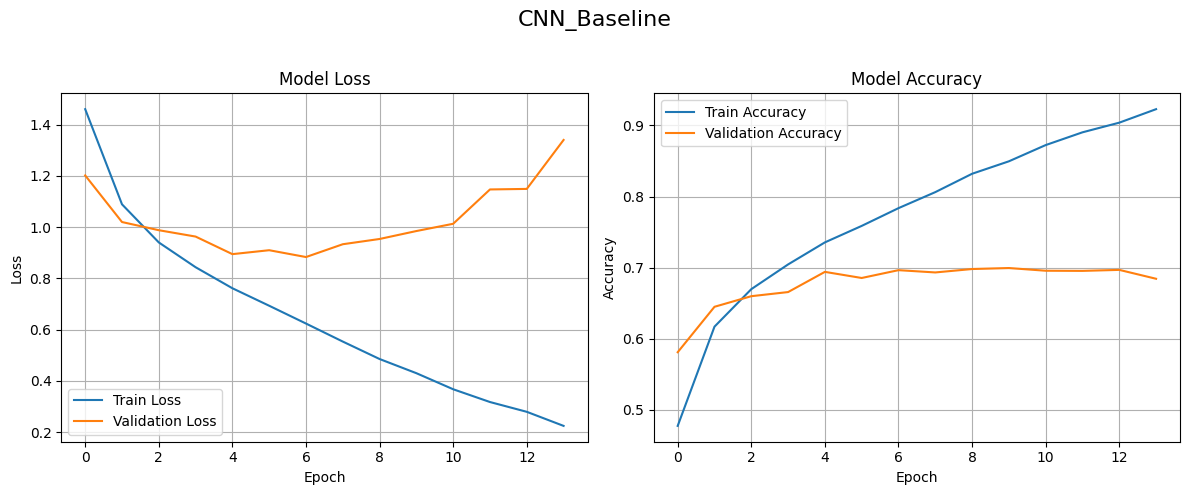


--- Evaluation Report for: CNN_Baseline ---
Test Loss: 0.8921
Test Accuracy: 0.6984
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6975

Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.69      0.72      1000
  automobile       0.81      0.81      0.81      1000
        bird       0.58      0.60      0.59      1000
         cat       0.51      0.51      0.51      1000
        deer       0.70      0.61      0.65      1000
         dog       0.62      0.59      0.61      1000
        frog       0.68      0.83      0.75      1000
       horse       0.77      0.75      0.76      1000
        ship       0.77      0.81      0.79      1000
       truck       0.78      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



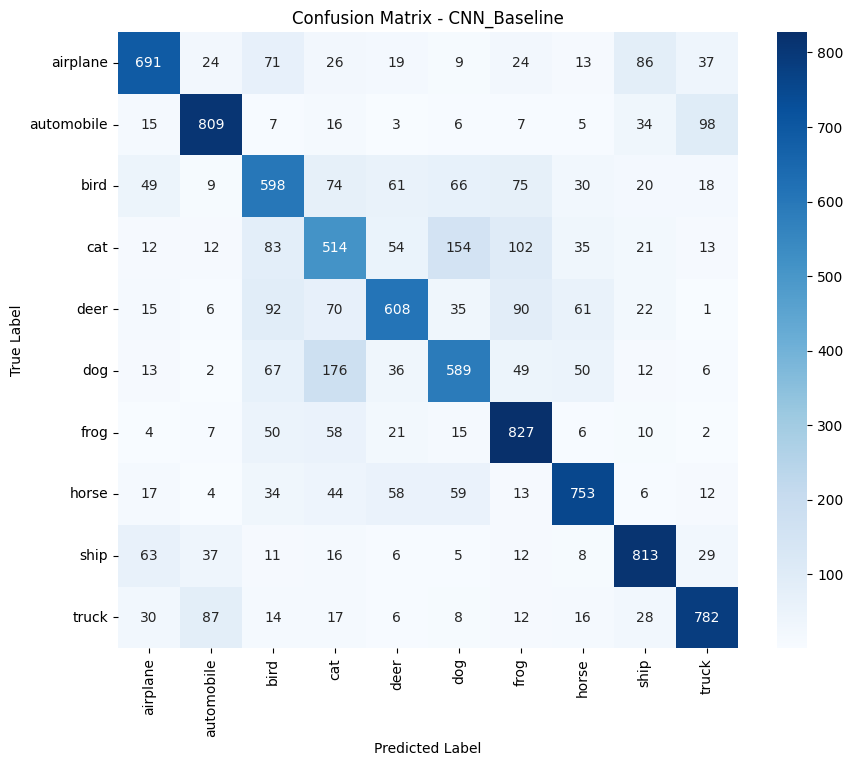

In [19]:
# Evaluasi Model Dasar
baseline_model.load_weights(baseline_model_path)  # Muat bobot terbaik
plot_training_history_local(
    history_baseline, baseline_model_name, baseline_model_name)
loss_base, acc_base, f1_base = evaluate_and_report_local(
    baseline_model, test_images, test_labels, baseline_model_name, cifar10_class_names, baseline_model_name)

In [20]:
# Variabel ini akan digunakan untuk perbandingan dengan model from scratch nanti
best_keras_model_for_fs_path = baseline_model_path

### 2.2 Eksperimen Hyperparameter

Fungsi untuk menjalankan set eksperimen dan menyimpan hasilnya.

In [21]:
def run_cnn_experiment(experiment_group_name, variations_dict, base_params_dict, param_to_vary_in_build_fn):
    all_experiment_results = {}
    all_histories_val_loss = {}

    print(f"\n\n{'='*20} Mulai Eksperimen: {experiment_group_name} {'='*20}")

    for var_name, var_value in variations_dict.items():
        current_model_name_slug = f"{experiment_group_name.replace(' ', '_')}_{var_name.replace(' ', '_')}"
        current_model_display_name = f"{experiment_group_name} - {var_name}"
        print(f"\n--- Melatih: {current_model_display_name} ---")

        current_build_params = base_params_dict.copy()
        current_build_params[param_to_vary_in_build_fn] = var_value

        model_exp = build_cnn_keras(
            input_shape=input_shape,
            num_classes=num_classes,
            **current_build_params
        )

        model_exp_path = os.path.join(
            models_save_dir, f"{current_model_name_slug}_best.keras")
        callbacks_exp = [
            # Patience lebih pendek untuk eksperimen
            EarlyStopping(monitor='val_loss', patience=5,
                          restore_best_weights=True, verbose=1),
            ModelCheckpoint(model_exp_path, save_best_only=True,
                            monitor='val_loss', verbose=0)
        ]

        history_exp = model_exp.fit(
            train_images, train_labels,
            # Pertimbangkan epoch lebih pendek untuk eksperimen
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(val_images, val_labels),
            callbacks=callbacks_exp, verbose=0
        )
        print(f"Selesai melatih {current_model_display_name}.")

        model_exp.load_weights(model_exp_path)
        plot_training_history_local(
            history_exp, current_model_display_name, current_model_name_slug)
        loss, acc, f1 = evaluate_and_report_local(
            model_exp, test_images, test_labels, current_model_display_name, cifar10_class_names, current_model_name_slug)

        all_experiment_results[current_model_display_name] = {
            'loss': loss, 'accuracy': acc, 'f1_score': f1, 'model_path': model_exp_path}
        all_histories_val_loss[current_model_display_name] = history_exp.history['val_loss']
        tf.keras.backend.clear_session()

    # Plot perbandingan validation loss untuk grup eksperimen ini
    plt.figure(figsize=(12, 7))
    for name, val_loss_hist in all_histories_val_loss.items():
        plt.plot(val_loss_hist, label=name)  # Label sudah termasuk nama grup
    plt.title(f'Perbandingan Validation Loss - {experiment_group_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend(loc='best')  # Biarkan matplotlib memilih lokasi terbaik
    plt.grid(True)
    # plt.tight_layout() # Mungkin tidak perlu jika legenda di 'best'
    plt.savefig(os.path.join(results_images_dir,
                f"{experiment_group_name.replace(' ', '_')}_val_loss_comparison.png"))
    plt.show()

    print(f"\n--- Hasil Akhir untuk Eksperimen: {experiment_group_name} ---")
    for name, metrics in all_experiment_results.items():
        print(
            f"{name}: Macro F1-Score = {metrics['f1_score']:.4f}, Accuracy = {metrics['accuracy']:.4f}")
    return all_experiment_results

#### 2.2.1 Pengaruh Jumlah Layer Konvolusi
Pilih 3 variasi.



==================== Mulai Eksperimen: Pengaruh Jumlah Layer Konvolusi ====================

--- Melatih: Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv.


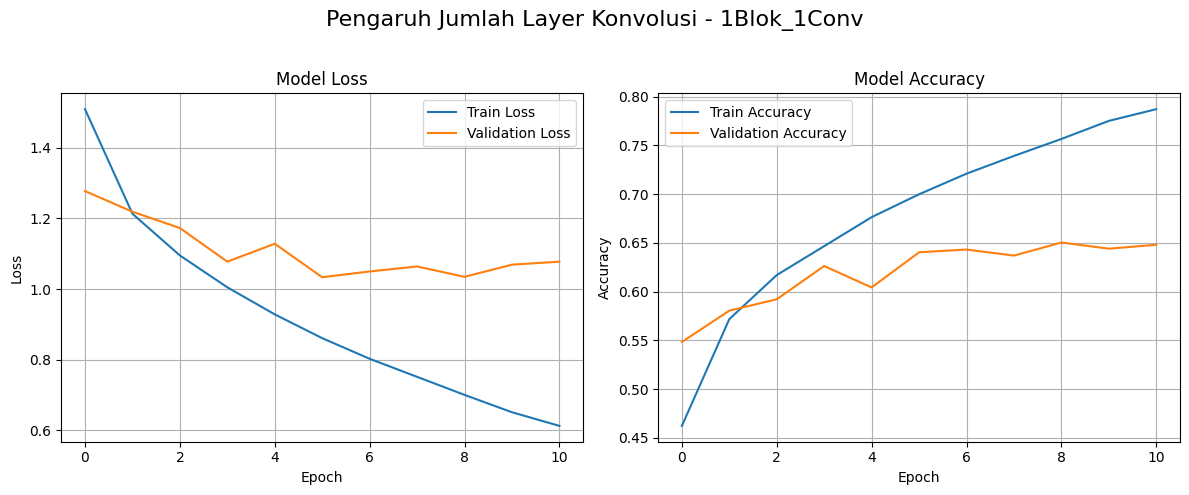


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv ---
Test Loss: 1.0381
Test Accuracy: 0.6427
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6399

Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.51      0.62      1000
  automobile       0.75      0.76      0.76      1000
        bird       0.50      0.54      0.52      1000
         cat       0.48      0.47      0.48      1000
        deer       0.58      0.64      0.61      1000
         dog       0.61      0.47      0.53      1000
        frog       0.73      0.74      0.74      1000
       horse       0.66      0.78      0.72      1000
        ship       0.69      0.78      0.73      1000
       truck       0.69      0.73      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



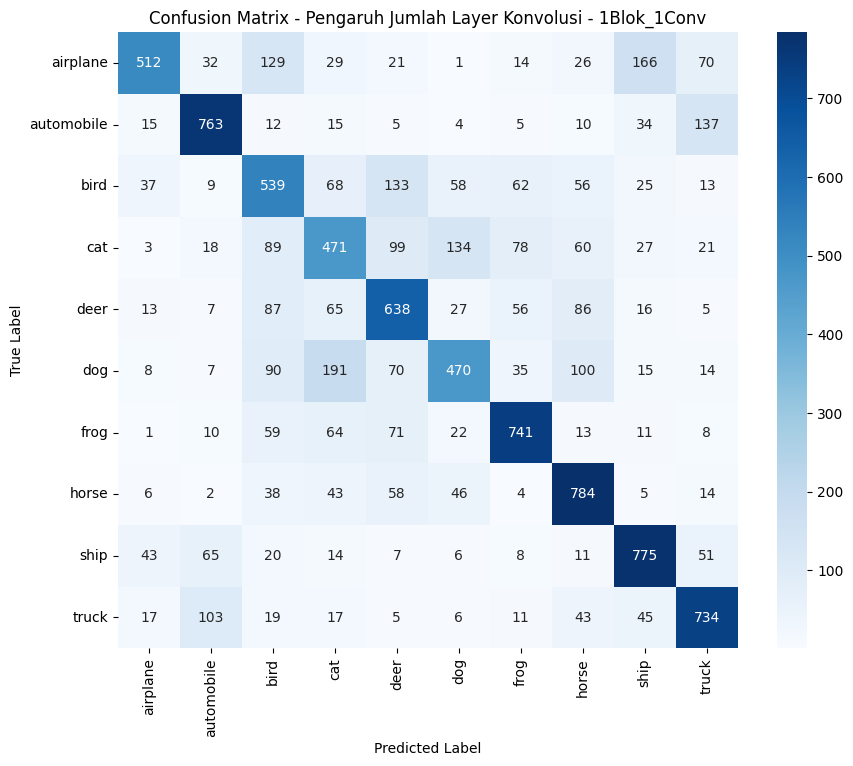


--- Melatih: Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer.


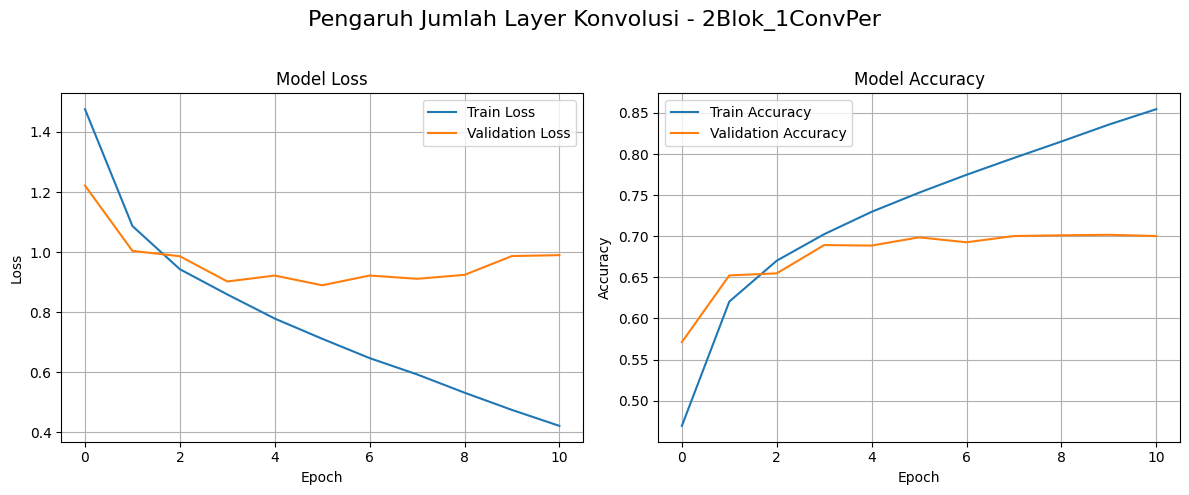


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer ---
Test Loss: 0.8875
Test Accuracy: 0.7019
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6978

Classification Report:
              precision    recall  f1-score   support

    airplane       0.64      0.84      0.72      1000
  automobile       0.81      0.83      0.82      1000
        bird       0.63      0.58      0.60      1000
         cat       0.57      0.42      0.49      1000
        deer       0.71      0.58      0.64      1000
         dog       0.59      0.64      0.61      1000
        frog       0.78      0.78      0.78      1000
       horse       0.75      0.77      0.76      1000
        ship       0.86      0.71      0.78      1000
       truck       0.70      0.85      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



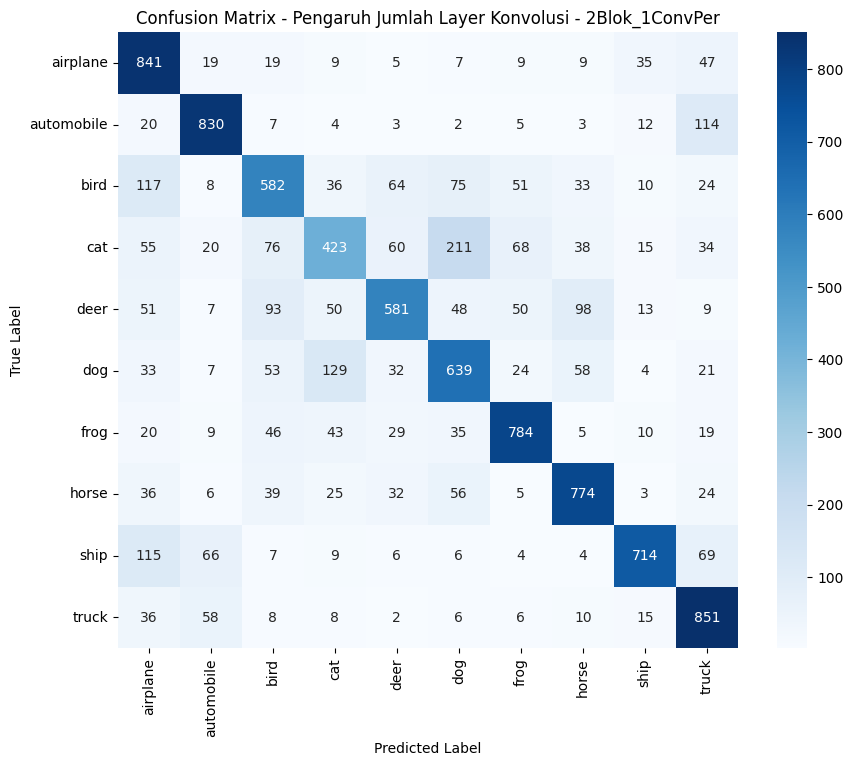


--- Melatih: Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer ---
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer.


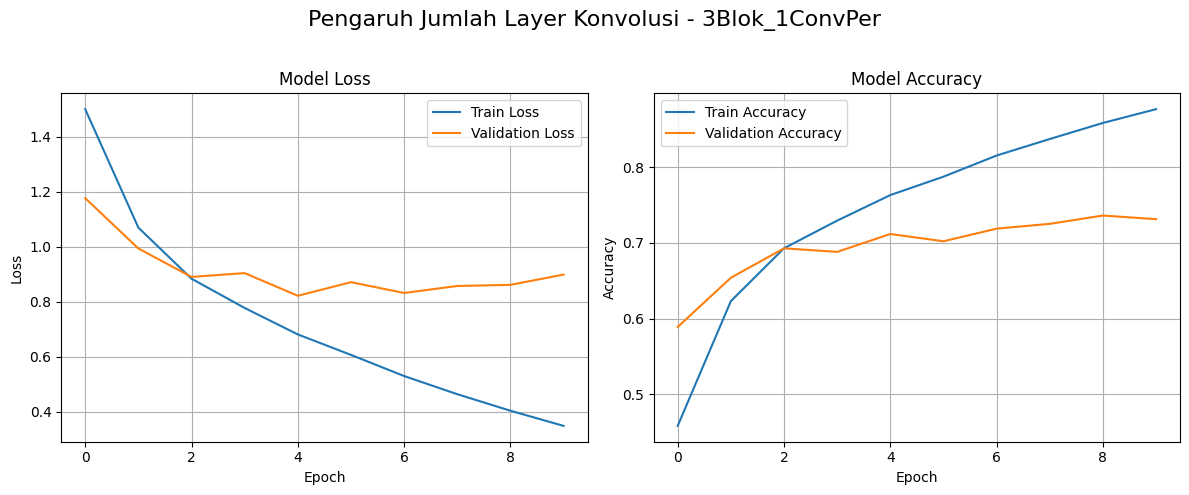


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer ---
Test Loss: 0.8212
Test Accuracy: 0.7194
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.7179

Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.70      0.76      1000
  automobile       0.87      0.83      0.85      1000
        bird       0.63      0.60      0.62      1000
         cat       0.55      0.49      0.52      1000
        deer       0.60      0.71      0.65      1000
         dog       0.74      0.54      0.62      1000
        frog       0.62      0.90      0.73      1000
       horse       0.81      0.75      0.78      1000
        ship       0.87      0.82      0.84      1000
       truck       0.76      0.85      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



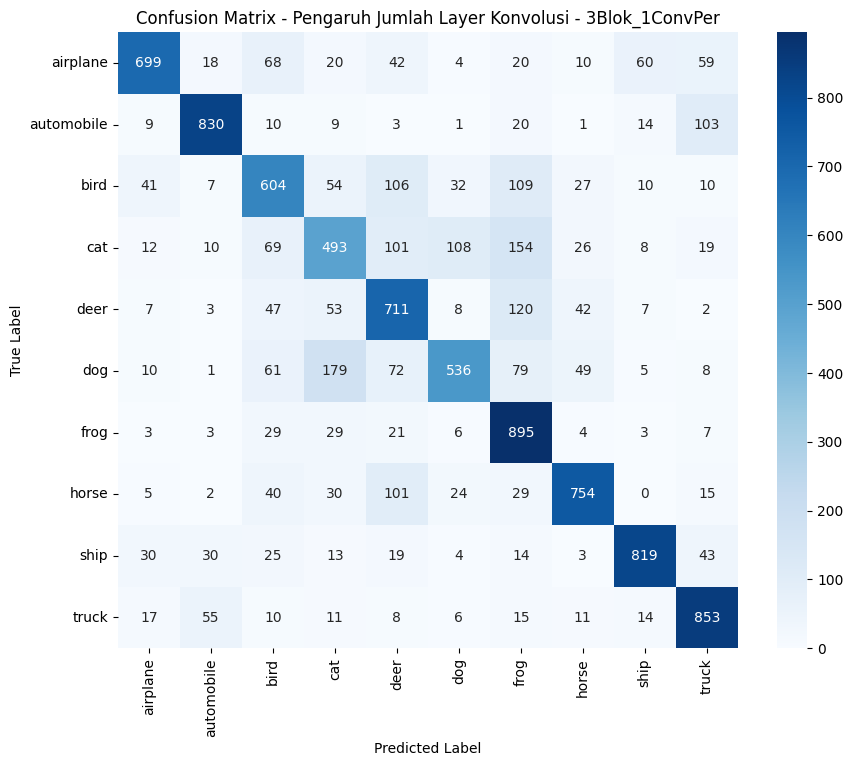

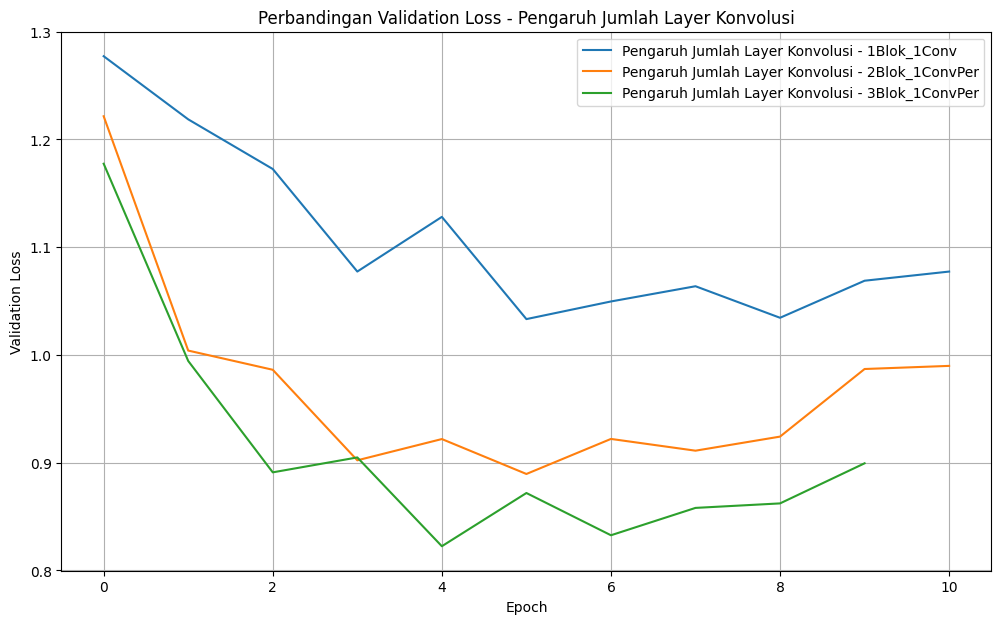


--- Hasil Akhir untuk Eksperimen: Pengaruh Jumlah Layer Konvolusi ---
Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv: Macro F1-Score = 0.6399, Accuracy = 0.6427
Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer: Macro F1-Score = 0.6978, Accuracy = 0.7019
Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer: Macro F1-Score = 0.7179, Accuracy = 0.7194


In [22]:
base_params_for_exp = {
    'pooling_type': baseline_pooling_type,
    'pooling_size': baseline_pooling_size,
    'use_global_pooling': baseline_use_global_pooling,
    'dense_layers_params': baseline_dense_config
}

conv_layer_variations = {
    "1Blok_1Conv": [{'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1}],
    "2Blok_1ConvPer": baseline_conv_config,  # Baseline
    "3Blok_1ConvPer": [
        {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 128, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ]
}
results_num_conv_layers = run_cnn_experiment(
    "Pengaruh Jumlah Layer Konvolusi",
    conv_layer_variations,
    base_params_for_exp,
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Jumlah Layer Konvolusi:**

*(Tulis kesimpulan Anda di sini berdasarkan F1-score dan grafik validation loss. Bagaimana jumlah blok konvolusi (atau total layer konvolusi) mempengaruhi kinerja?)*

#### 2.2.2 Pengaruh Banyak Filter per Layer Konvolusi
Pilih 3 variasi. (Struktur blok konvolusi tetap seperti baseline: 2 blok, 1 conv per blok)



==================== Mulai Eksperimen: Pengaruh Banyak Filter ====================

--- Melatih: Pengaruh Banyak Filter - FilterKecil_16_32 ---
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
Selesai melatih Pengaruh Banyak Filter - FilterKecil_16_32.


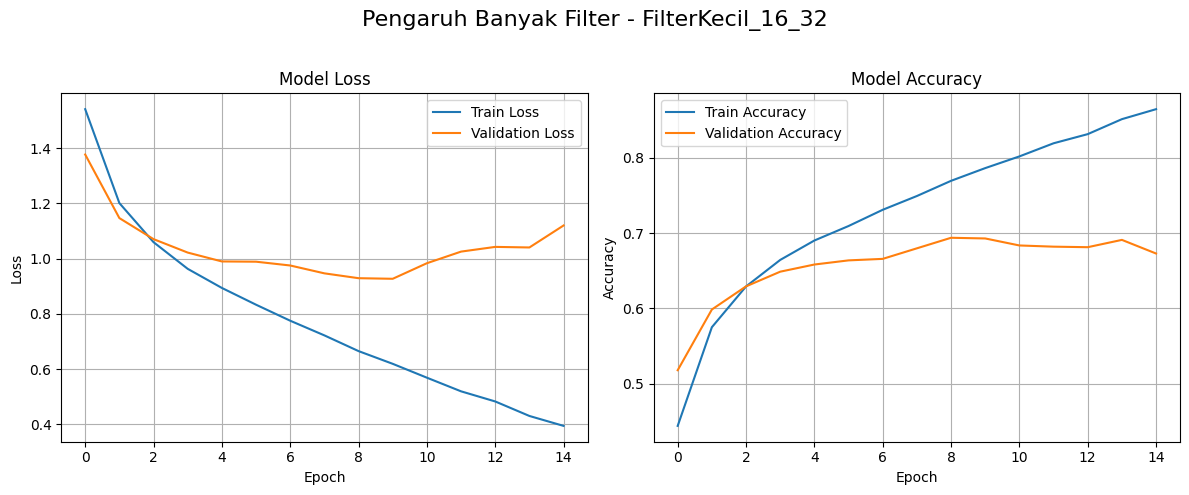


--- Evaluation Report for: Pengaruh Banyak Filter - FilterKecil_16_32 ---
Test Loss: 0.9335
Test Accuracy: 0.6923
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6923

Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.73      0.73      1000
  automobile       0.78      0.82      0.80      1000
        bird       0.59      0.56      0.58      1000
         cat       0.52      0.51      0.52      1000
        deer       0.66      0.61      0.63      1000
         dog       0.57      0.64      0.60      1000
        frog       0.74      0.77      0.75      1000
       horse       0.73      0.78      0.75      1000
        ship       0.84      0.77      0.80      1000
       truck       0.79      0.73      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



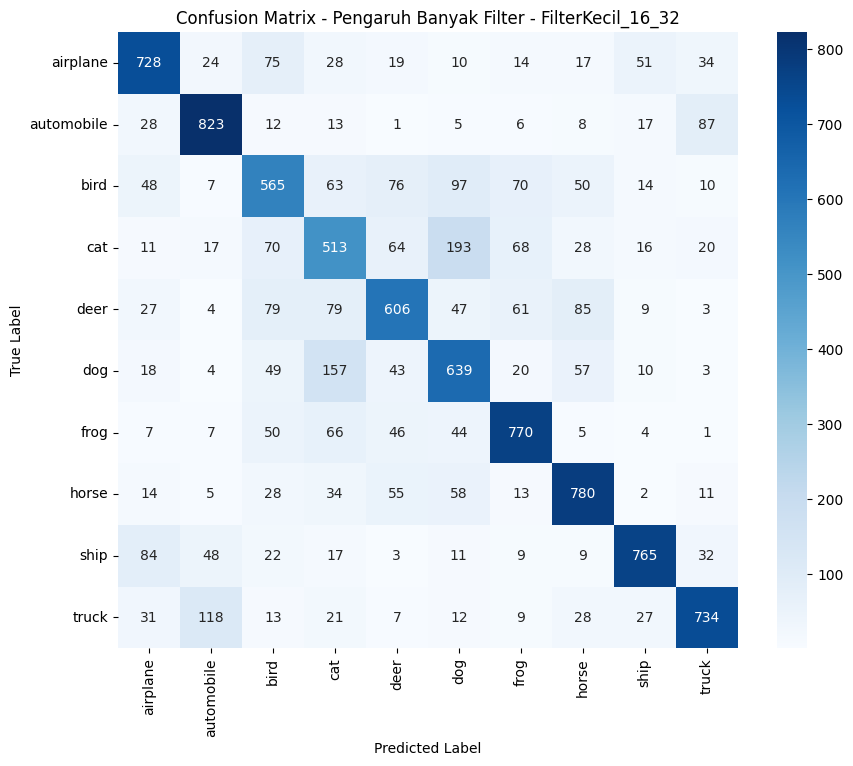


--- Melatih: Pengaruh Banyak Filter - FilterSedang_32_64 ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Selesai melatih Pengaruh Banyak Filter - FilterSedang_32_64.


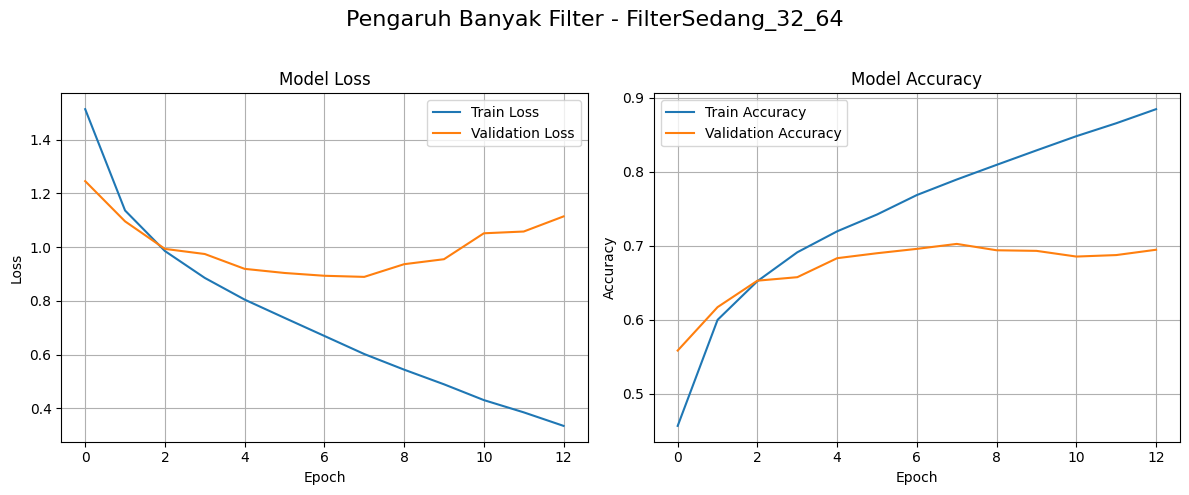


--- Evaluation Report for: Pengaruh Banyak Filter - FilterSedang_32_64 ---
Test Loss: 0.8883
Test Accuracy: 0.7062
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.7058

Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.81      0.73      1000
  automobile       0.81      0.80      0.81      1000
        bird       0.58      0.60      0.59      1000
         cat       0.57      0.49      0.53      1000
        deer       0.60      0.73      0.66      1000
         dog       0.67      0.59      0.62      1000
        frog       0.85      0.70      0.77      1000
       horse       0.76      0.78      0.77      1000
        ship       0.86      0.76      0.81      1000
       truck       0.75      0.79      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



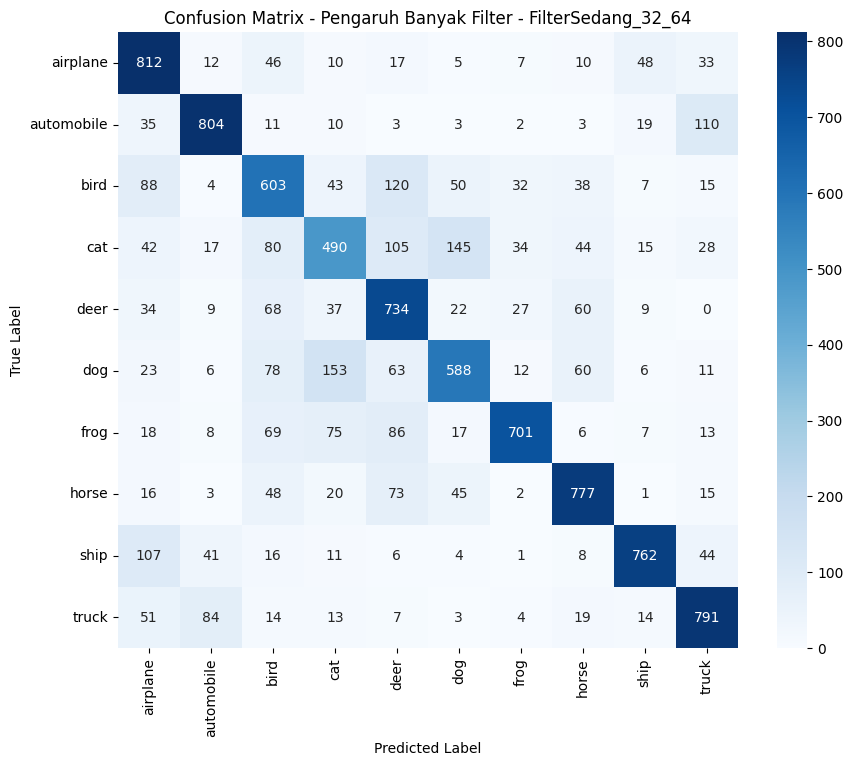


--- Melatih: Pengaruh Banyak Filter - FilterBesar_64_128 ---
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
Selesai melatih Pengaruh Banyak Filter - FilterBesar_64_128.


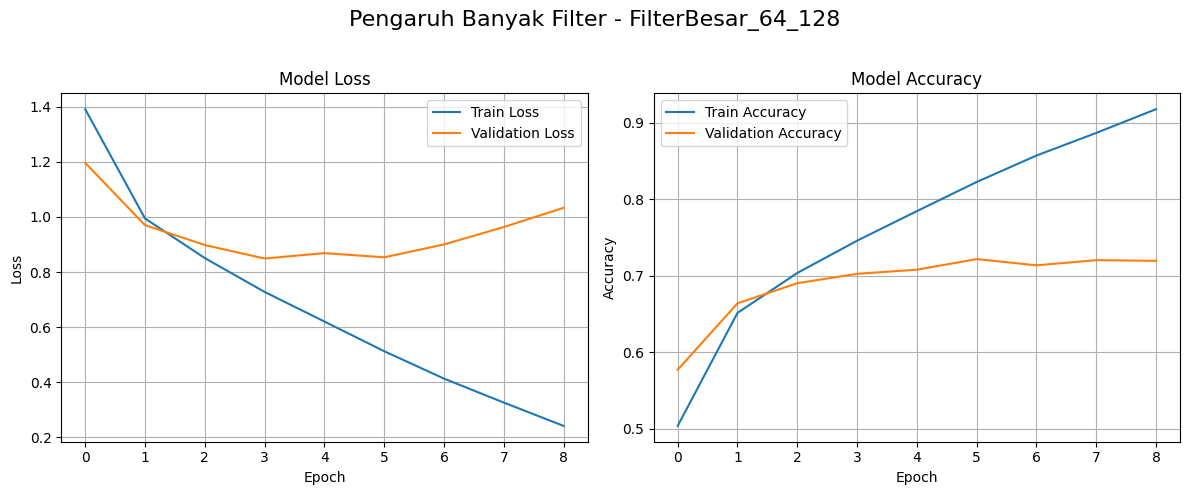


--- Evaluation Report for: Pengaruh Banyak Filter - FilterBesar_64_128 ---
Test Loss: 0.8580
Test Accuracy: 0.7020
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6999

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.75      0.76      1000
  automobile       0.83      0.81      0.82      1000
        bird       0.57      0.60      0.58      1000
         cat       0.55      0.51      0.53      1000
        deer       0.72      0.52      0.60      1000
         dog       0.63      0.61      0.62      1000
        frog       0.64      0.87      0.74      1000
       horse       0.75      0.78      0.76      1000
        ship       0.87      0.76      0.81      1000
       truck       0.73      0.83      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



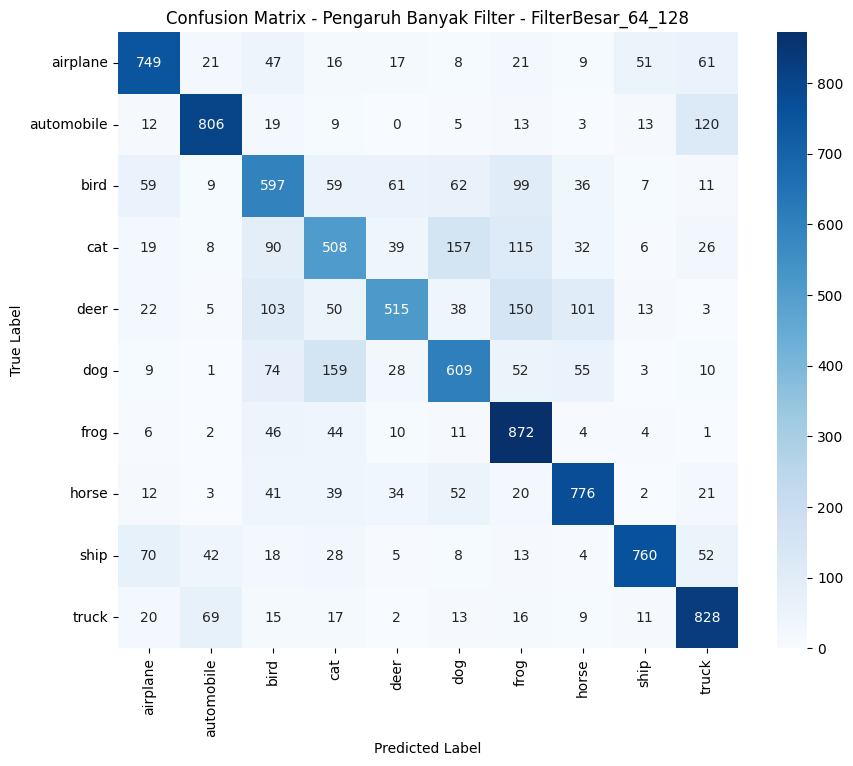

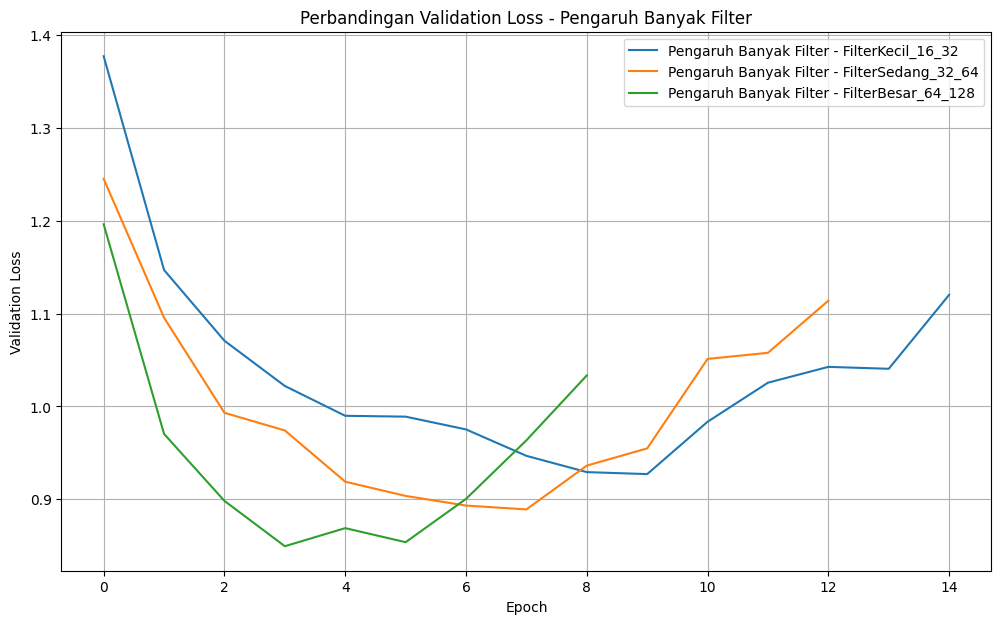


--- Hasil Akhir untuk Eksperimen: Pengaruh Banyak Filter ---
Pengaruh Banyak Filter - FilterKecil_16_32: Macro F1-Score = 0.6923, Accuracy = 0.6923
Pengaruh Banyak Filter - FilterSedang_32_64: Macro F1-Score = 0.7058, Accuracy = 0.7062
Pengaruh Banyak Filter - FilterBesar_64_128: Macro F1-Score = 0.6999, Accuracy = 0.7020


In [23]:
num_filter_variations = {
    "FilterKecil_16_32": [
        {'filters': 16, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ],
    "FilterSedang_32_64": baseline_conv_config,  # Baseline
    "FilterBesar_64_128": [
        {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 128, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ]
}
results_num_filters = run_cnn_experiment(
    "Pengaruh Banyak Filter",
    num_filter_variations,
    base_params_for_exp,  # Menggunakan base_params_for_exp yang sama
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Banyak Filter:**

*(Tulis kesimpulan Anda di sini. Bagaimana jumlah filter mempengaruhi representasi fitur dan kinerja?)*

#### 2.2.3 Pengaruh Ukuran Filter per Layer Konvolusi
Pilih 3 variasi. (Struktur blok dan jumlah filter tetap seperti baseline)



==================== Mulai Eksperimen: Pengaruh Ukuran Filter ====================

--- Melatih: Pengaruh Ukuran Filter - Kernel_2x2 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Ukuran Filter - Kernel_2x2.


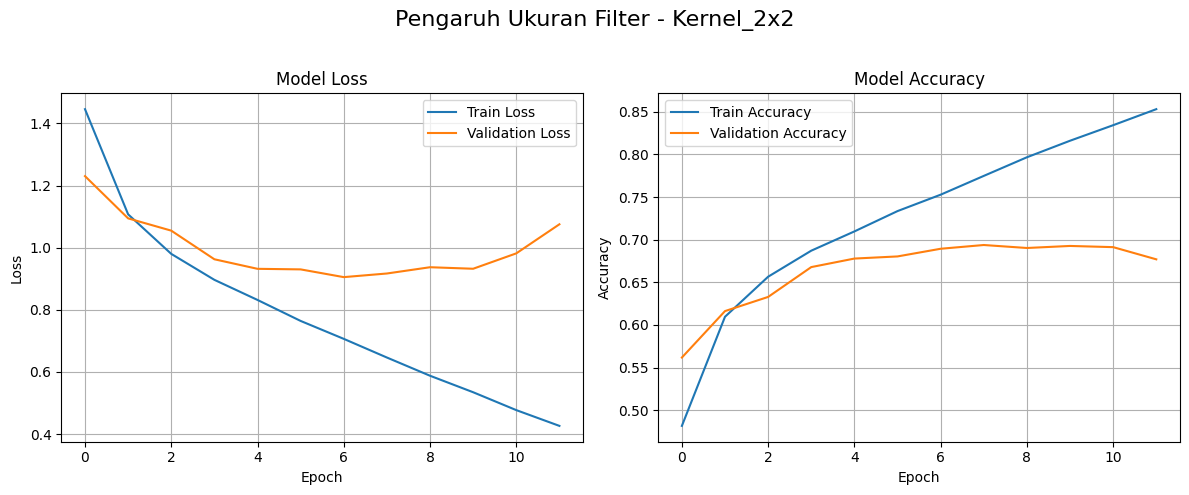


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_2x2 ---
Test Loss: 0.8893
Test Accuracy: 0.6965
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6942

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.72      0.73      1000
  automobile       0.80      0.80      0.80      1000
        bird       0.55      0.60      0.58      1000
         cat       0.54      0.48      0.51      1000
        deer       0.62      0.70      0.66      1000
         dog       0.71      0.53      0.60      1000
        frog       0.79      0.75      0.77      1000
       horse       0.72      0.78      0.75      1000
        ship       0.73      0.85      0.78      1000
       truck       0.77      0.76      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000



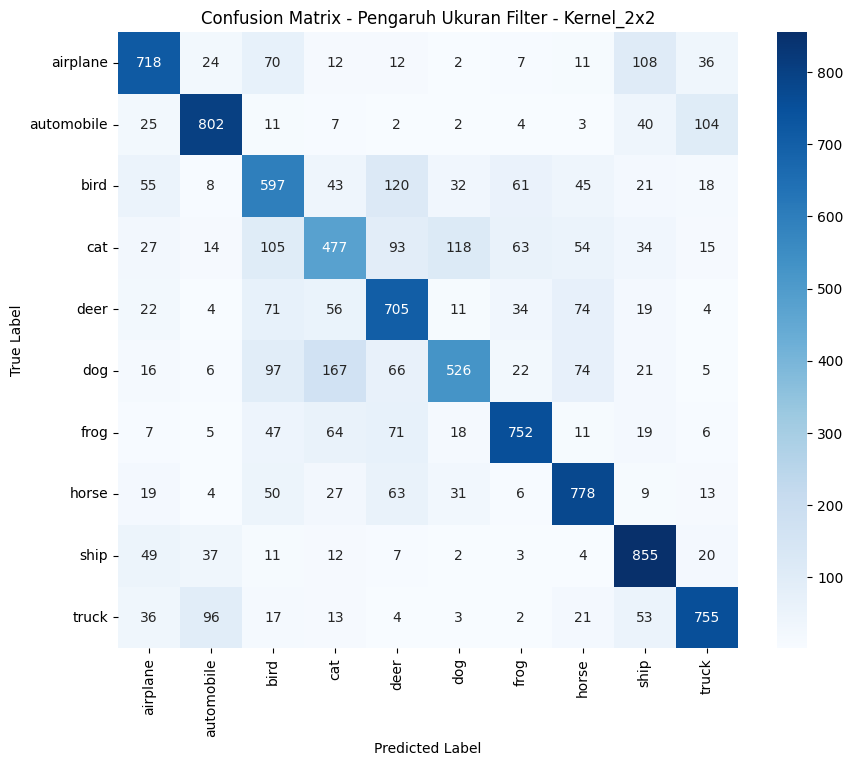


--- Melatih: Pengaruh Ukuran Filter - Kernel_3x3 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Ukuran Filter - Kernel_3x3.


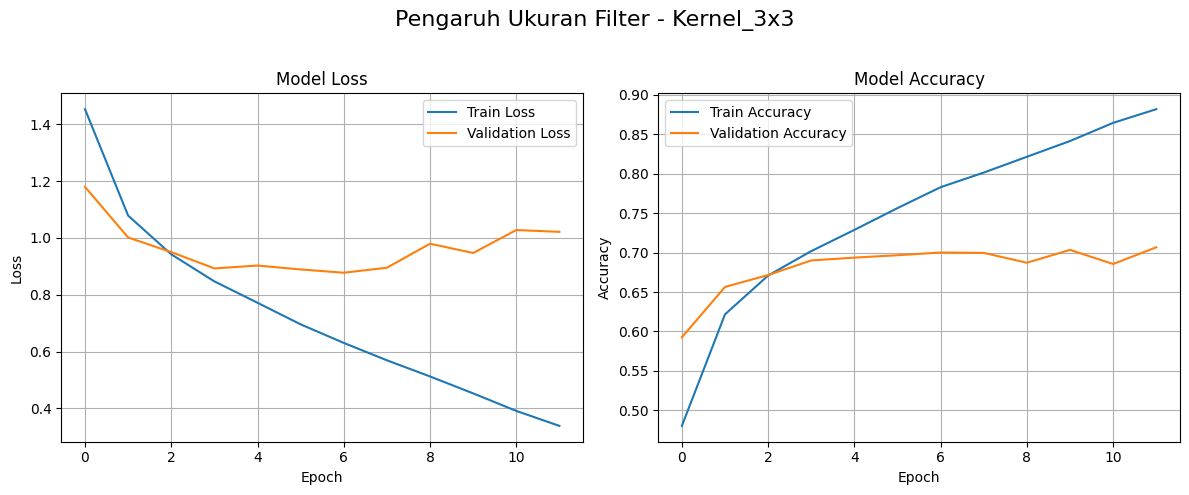


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_3x3 ---
Test Loss: 0.8737
Test Accuracy: 0.7085
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.7086

Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.75      0.76      1000
  automobile       0.86      0.74      0.79      1000
        bird       0.60      0.62      0.61      1000
         cat       0.55      0.49      0.52      1000
        deer       0.63      0.69      0.66      1000
         dog       0.59      0.66      0.62      1000
        frog       0.81      0.78      0.80      1000
       horse       0.78      0.71      0.74      1000
        ship       0.78      0.84      0.81      1000
       truck       0.75      0.80      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



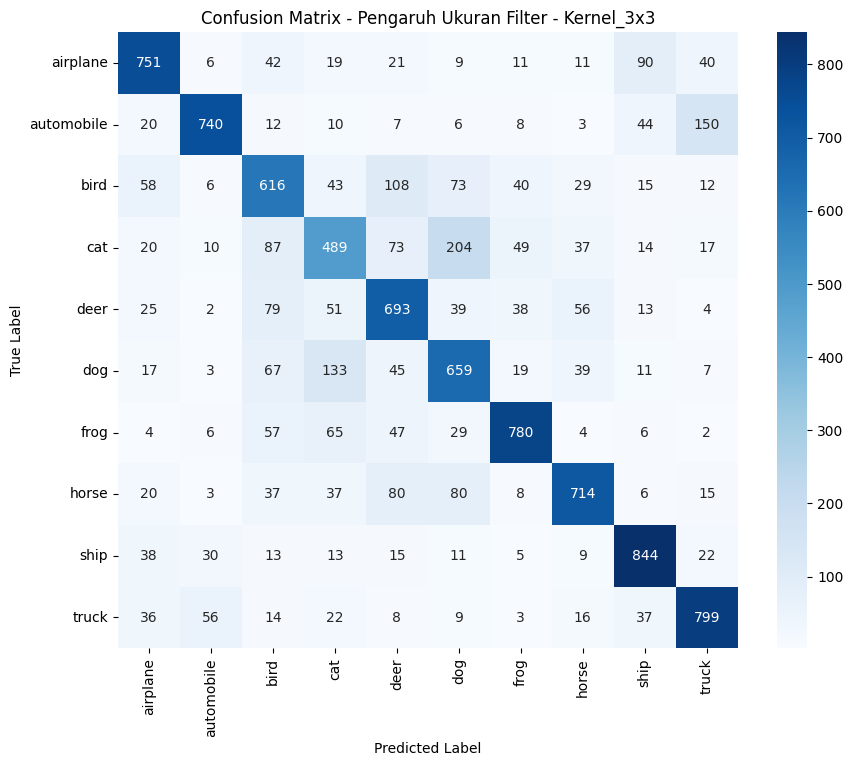


--- Melatih: Pengaruh Ukuran Filter - Kernel_5x5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Ukuran Filter - Kernel_5x5.


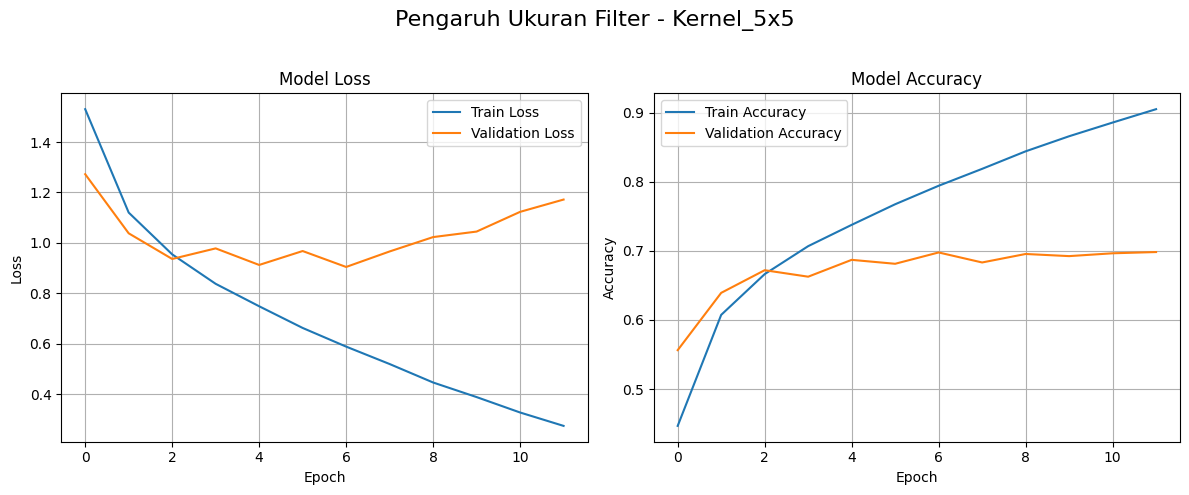


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_5x5 ---
Test Loss: 0.9052
Test Accuracy: 0.6989
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6978

Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.67      0.73      1000
  automobile       0.81      0.83      0.82      1000
        bird       0.61      0.57      0.59      1000
         cat       0.51      0.46      0.48      1000
        deer       0.65      0.67      0.66      1000
         dog       0.57      0.64      0.60      1000
        frog       0.78      0.75      0.76      1000
       horse       0.74      0.76      0.75      1000
        ship       0.80      0.84      0.82      1000
       truck       0.72      0.80      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



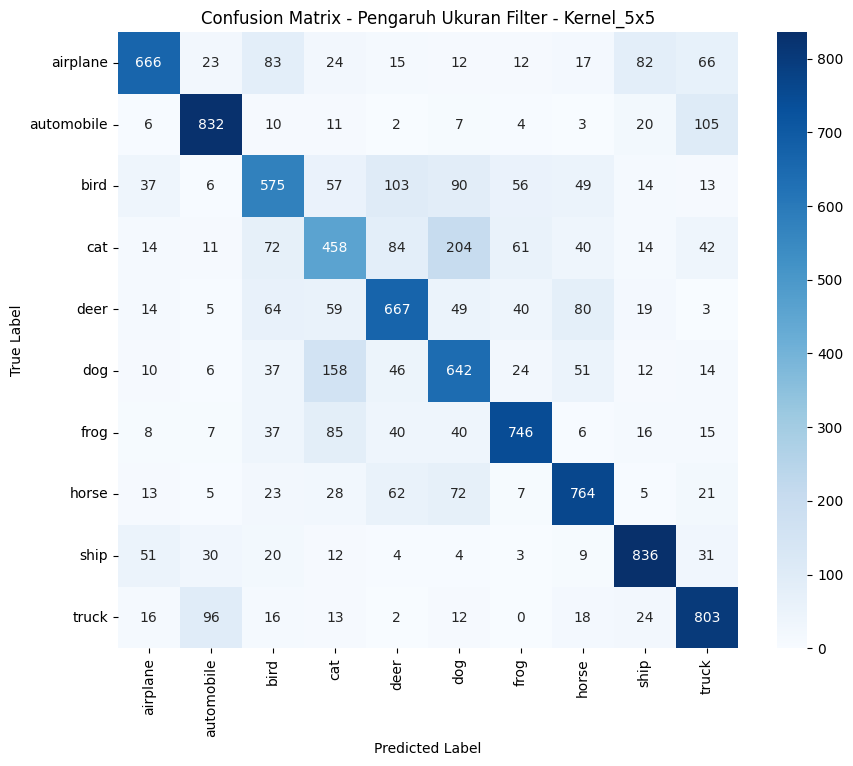

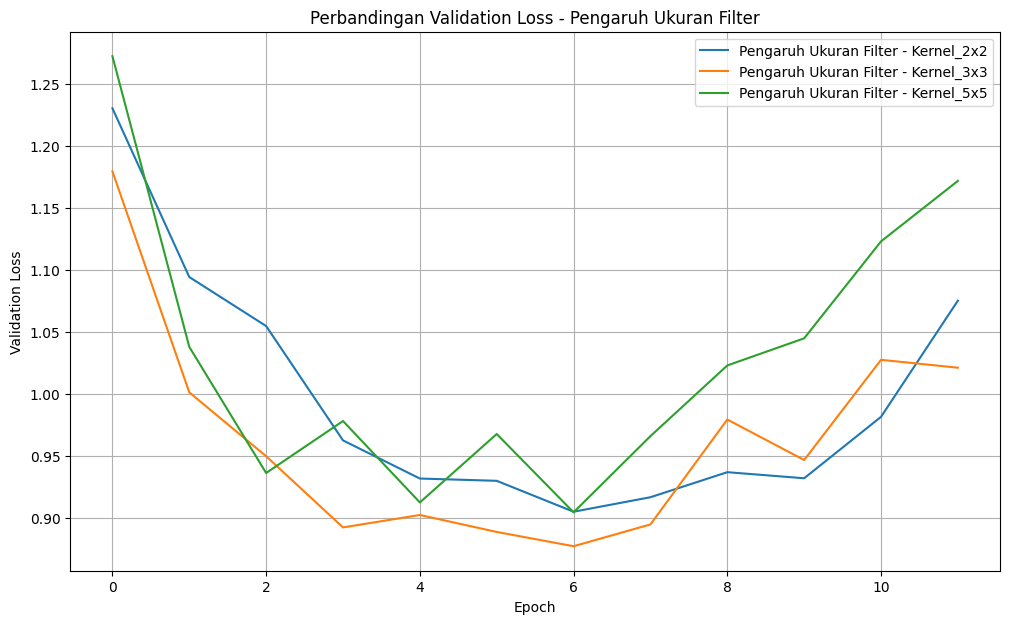


--- Hasil Akhir untuk Eksperimen: Pengaruh Ukuran Filter ---
Pengaruh Ukuran Filter - Kernel_2x2: Macro F1-Score = 0.6942, Accuracy = 0.6965
Pengaruh Ukuran Filter - Kernel_3x3: Macro F1-Score = 0.7086, Accuracy = 0.7085
Pengaruh Ukuran Filter - Kernel_5x5: Macro F1-Score = 0.6978, Accuracy = 0.6989


In [24]:
def generate_conv_config_with_new_kernel(base_conv_conf, new_kernel_size):
    new_conf = []
    for block in base_conv_conf:  # base_conv_conf di sini adalah list dari dict
        modified_block = block.copy()
        modified_block['kernel_size'] = new_kernel_size
        new_conf.append(modified_block)
    return new_conf


kernel_size_variations_configs = {
    "Kernel_2x2": generate_conv_config_with_new_kernel(baseline_conv_config, (2, 2)),
    "Kernel_3x3": baseline_conv_config,  # Baseline
    "Kernel_5x5": generate_conv_config_with_new_kernel(baseline_conv_config, (5, 5)),
}

results_kernel_size = run_cnn_experiment(
    "Pengaruh Ukuran Filter",
    kernel_size_variations_configs,
    # Base params tidak termasuk conv_blocks_params di sini karena di-override
    base_params_for_exp,
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Ukuran Filter:**

*(Tulis kesimpulan Anda di sini. Bagaimana ukuran filter mempengaruhi deteksi fitur spasial?)*

#### 2.2.4 Pengaruh Jenis Pooling Layer
Pilih 2 variasi: Max Pooling vs Average Pooling.



==================== Mulai Eksperimen: Pengaruh Jenis Pooling Layer ====================

--- Melatih: Pengaruh Jenis Pooling Layer - MaxPooling ---
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Selesai melatih Pengaruh Jenis Pooling Layer - MaxPooling.


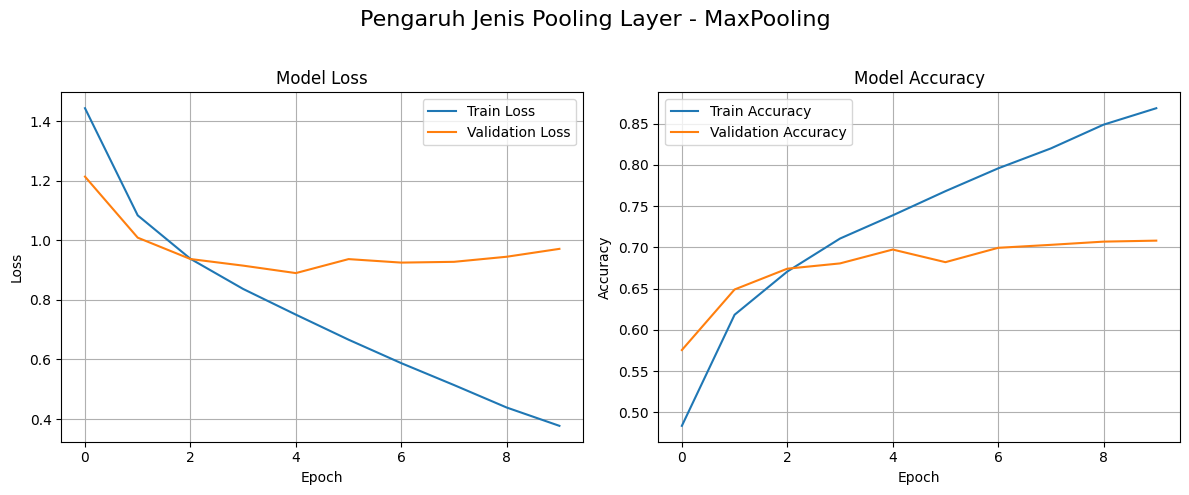


--- Evaluation Report for: Pengaruh Jenis Pooling Layer - MaxPooling ---
Test Loss: 0.8943
Test Accuracy: 0.6942
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6921

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.69      0.73      1000
  automobile       0.79      0.82      0.81      1000
        bird       0.60      0.53      0.56      1000
         cat       0.56      0.43      0.48      1000
        deer       0.55      0.77      0.64      1000
         dog       0.62      0.62      0.62      1000
        frog       0.71      0.83      0.76      1000
       horse       0.78      0.73      0.76      1000
        ship       0.80      0.77      0.79      1000
       truck       0.80      0.75      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



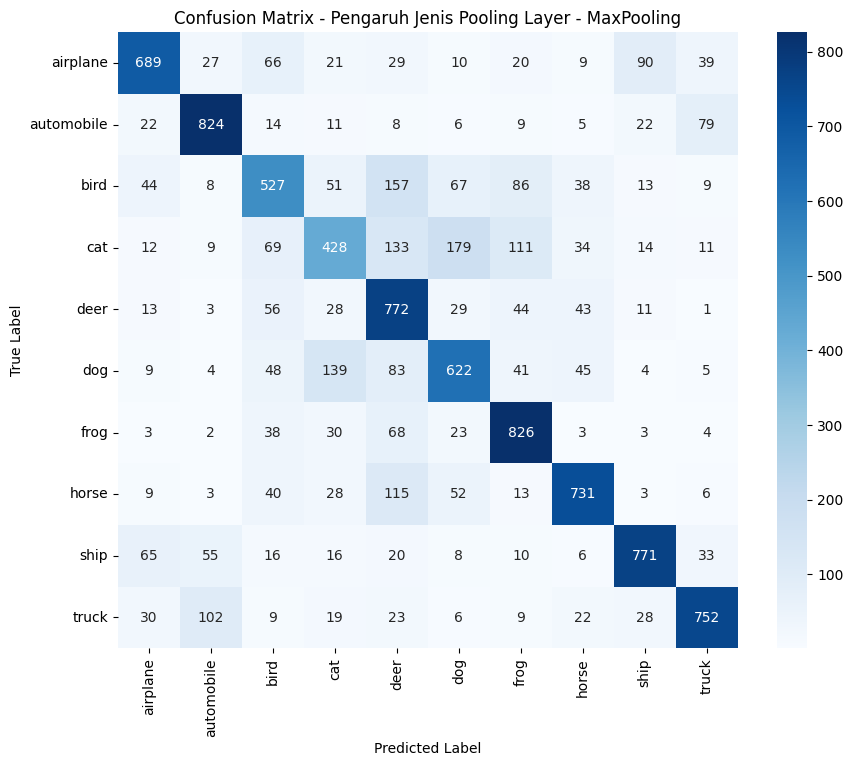


--- Melatih: Pengaruh Jenis Pooling Layer - AveragePooling ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Selesai melatih Pengaruh Jenis Pooling Layer - AveragePooling.


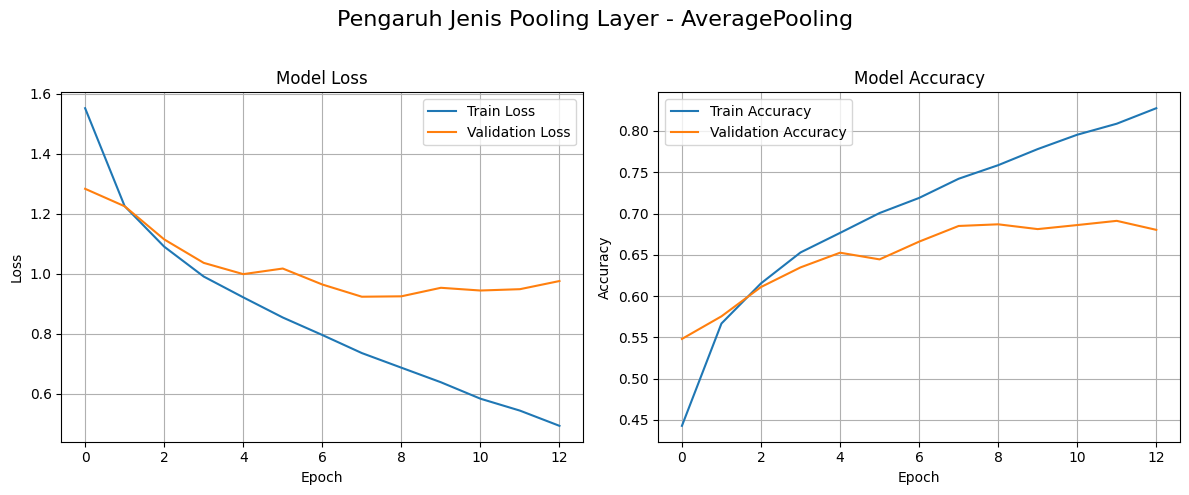


--- Evaluation Report for: Pengaruh Jenis Pooling Layer - AveragePooling ---
Test Loss: 0.9199
Test Accuracy: 0.6859
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6854

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.74      0.74      1000
  automobile       0.83      0.75      0.79      1000
        bird       0.67      0.47      0.55      1000
         cat       0.52      0.49      0.50      1000
        deer       0.56      0.70      0.62      1000
         dog       0.56      0.62      0.59      1000
        frog       0.76      0.74      0.75      1000
       horse       0.75      0.76      0.76      1000
        ship       0.83      0.78      0.80      1000
       truck       0.71      0.80      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



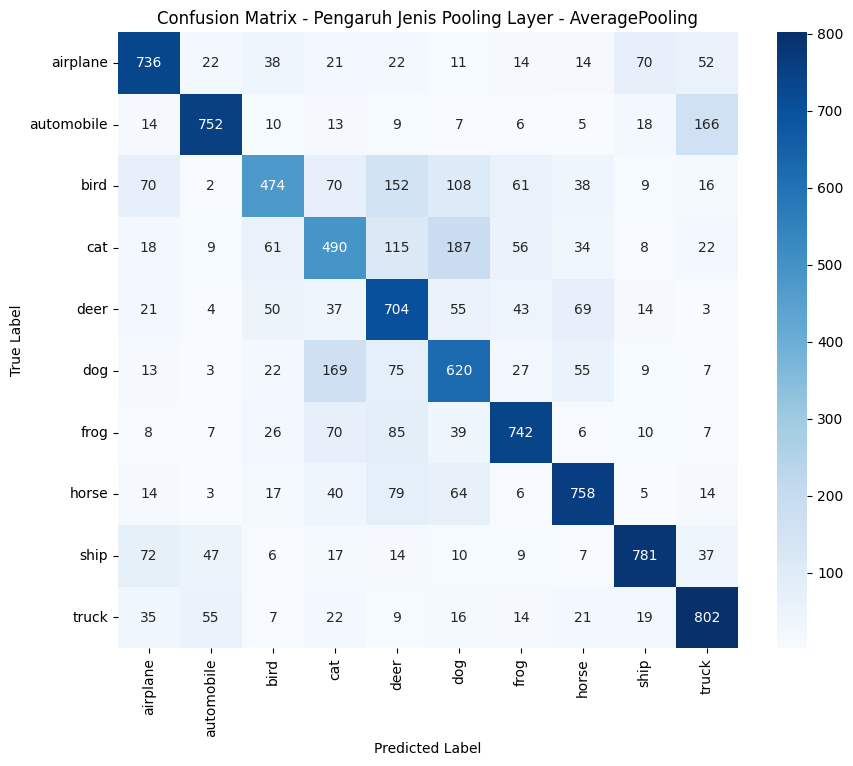

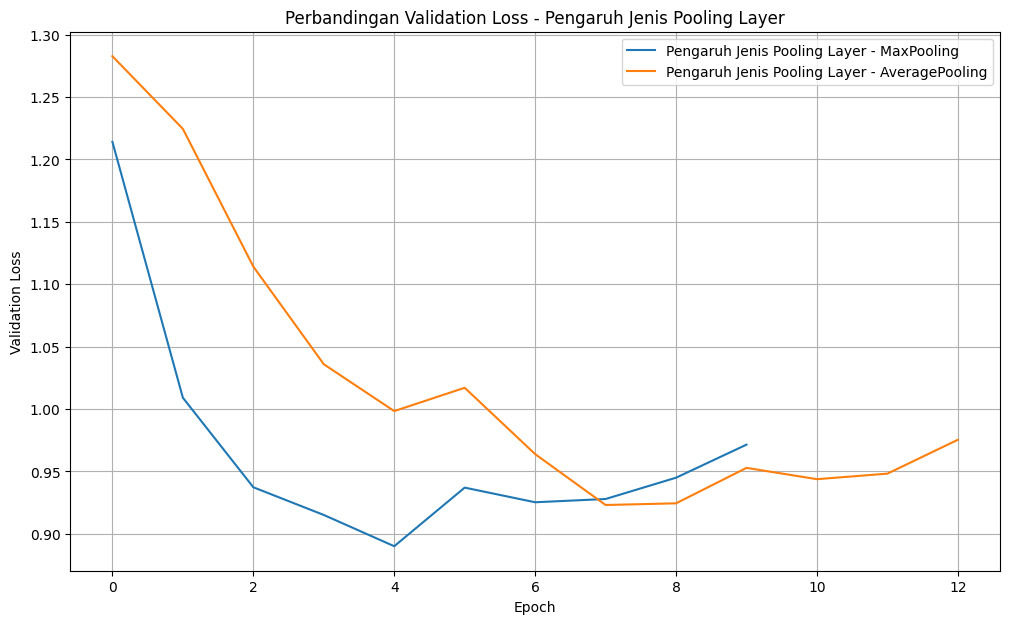


--- Hasil Akhir untuk Eksperimen: Pengaruh Jenis Pooling Layer ---
Pengaruh Jenis Pooling Layer - MaxPooling: Macro F1-Score = 0.6921, Accuracy = 0.6942
Pengaruh Jenis Pooling Layer - AveragePooling: Macro F1-Score = 0.6854, Accuracy = 0.6859


In [25]:
base_params_for_pooling_exp = {
    'conv_blocks_params': baseline_conv_config,
    'pooling_size': baseline_pooling_size,
    'use_global_pooling': baseline_use_global_pooling,
    'dense_layers_params': baseline_dense_config
}

pooling_type_variations = {
    "MaxPooling": "max",  # Baseline
    "AveragePooling": "average"
}
results_pooling_type = run_cnn_experiment(
    "Pengaruh Jenis Pooling Layer",
    pooling_type_variations,
    base_params_for_pooling_exp,
    'pooling_type'
)

**Kesimpulan Pengaruh Jenis Pooling Layer:**

*(Tulis kesimpulan Anda di sini. Manakah yang memberikan hasil lebih baik untuk kasus ini? Apa alasannya?)*


## SECTION 3: Implementasi Forward Propagation CNN from Scratch

Membuat model CNN *from scratch* yang arsitekturnya sama dengan model Keras terbaik (misalnya, `baseline_model`).
Model *from scratch* harus bisa membaca bobot dari model Keras. Implementasi modular per layer.
Dense layer boleh dari Tubes 1.

### 3.1 Membangun Model CNN From Scratch

Arsitektur harus sama dengan model Keras yang bobotnya akan dimuat (misalnya, `baseline_model` yang disimpan di `best_keras_model_for_fs_path`).
**PENTING**: Anda harus sudah mengimplementasikan kelas `CNNModelFS` di file `src/models_from_scratch/cnn_fs.py` dan semua layer FS di `src/CNN/`.

In [26]:
# Muat kembali model Keras yang akan dijadikan acuan
print(f"Memuat model Keras referensi dari: {best_keras_model_for_fs_path}")
try:
    keras_model_ref = tf.keras.models.load_model(best_keras_model_for_fs_path)
    keras_model_ref.summary()  # Untuk referensi arsitektur
except Exception as e:
    print(f"Gagal memuat model Keras referensi: {e}")
    print("Pastikan path model benar dan model sudah dilatih.")
    keras_model_ref = None  # Set ke None jika gagal

Memuat model Keras referensi dari: saved_models_cnn/CNN_Baseline_best.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,296 (6.24 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,090,198 (4.16 MB)

Bangun arsitektur CNNModelFS sesuai keras_model_ref

Arsitektur baseline_model:
Input -> Conv2D(32, (3,3), padding='same') -> ReLU -> MaxPooling2D((2,2)) ->
Conv2D(64, (3,3), padding='same') -> ReLU -> MaxPooling2D((2,2)) ->
Flatten ->
Dense(128) -> ReLU ->
Dense(10, 'softmax')

In [27]:
cnn_fs = None
if 'CNNModelFS' in globals() and keras_model_ref is not None:  # Cek apakah CNNModelFS berhasil diimpor
    cnn_fs = CNNModelFS()

    # Blok 1
    cnn_fs.add_layer(Conv2DLayerFS(
        num_filters=32, kernel_size=(3, 3), padding='same'))
    cnn_fs.add_layer(ReLULayerFS())
    cnn_fs.add_layer(MaxPooling2DLayerFS(pool_size=(2, 2)))

    # Blok 2
    cnn_fs.add_layer(Conv2DLayerFS(
        num_filters=64, kernel_size=(3, 3), padding='same'))
    cnn_fs.add_layer(ReLULayerFS())
    cnn_fs.add_layer(MaxPooling2DLayerFS(pool_size=(2, 2)))

    # Flatten & Dense
    cnn_fs.add_layer(FlattenLayerFS())
    # Asumsi DenseLayerFS menangani aktivasi
    cnn_fs.add_layer(DenseLayerFS(num_units=128, activation_name='relu'))
    cnn_fs.add_layer(DenseLayerFS(
        num_units=num_classes, activation_name='softmax'))

    print("\nArsitektur CNNModelFS yang dibuat:")
    for i, layer_fs_instance in enumerate(cnn_fs.layers):
        print(f"Layer FS {i+1}: {layer_fs_instance}")
else:
    print("Tidak dapat membuat CNNModelFS karena kelas tidak terdefinisi atau model Keras referensi tidak ada.")


Arsitektur CNNModelFS yang dibuat:
Layer FS 1: Conv2DLayerFS(num_filters=32, kernel_size=(3, 3), stride=(1,1), padding='same')
Layer FS 2: ReLULayerFS()
Layer FS 3: MaxPooling2DLayerFS(pool_size=(2,2), stride=(2,2))
Layer FS 4: Conv2DLayerFS(num_filters=64, kernel_size=(3, 3), stride=(1,1), padding='same')
Layer FS 5: ReLULayerFS()
Layer FS 6: MaxPooling2DLayerFS(pool_size=(2,2), stride=(2,2))
Layer FS 7: FlattenLayerFS()
Layer FS 8: DenseLayerFS(num_units=128, activation='relu')
Layer FS 9: DenseLayerFS(num_units=10, activation='softmax')


### 3.2 Memuat Bobot dari Keras ke Model From Scratch

In [28]:
if cnn_fs and keras_model_ref:
    try:
        cnn_fs.load_keras_weights(keras_model_ref)
    except AttributeError:
        print("ERROR: Method 'load_keras_weights' tidak ditemukan di CNNModelFS.")
    except Exception as e:
        print(f"Error saat memuat bobot Keras ke model FS: {e}")
else:
    print("Model FS atau Keras referensi tidak tersedia untuk memuat bobot.")


Memulai pemuatan bobot Keras ke model FromScratch (versi optimasi)...
  Ditemukan 4 layer FS yang mengharapkan bobot.
  Ditemukan 4 layer Keras yang memiliki bobot.
  Mencoba memuat: FS L1 (Conv2DLayerFS) <- Keras L1 (conv2d, Conv2D)
[Conv2DLayerFS] Info: Input channels inferred from weights: 3
    Bobot berhasil dimuat.
  Mencoba memuat: FS L2 (Conv2DLayerFS) <- Keras L2 (conv2d_1, Conv2D)
[Conv2DLayerFS] Info: Input channels inferred from weights: 32
    Bobot berhasil dimuat.
  Mencoba memuat: FS L3 (DenseLayerFS) <- Keras L3 (dense, Dense)
    Bobot berhasil dimuat.
  Mencoba memuat: FS L4 (DenseLayerFS) <- Keras L4 (dense_1, Dense)
    Bobot berhasil dimuat.
Selesai memuat bobot Keras.


## SECTION 4: Pengujian dan Perbandingan Model From Scratch dengan Keras

Menggunakan data test dan metrik macro f1-score.

In [29]:
# Pilih beberapa sampel dari test set untuk perbandingan output detail
num_samples_for_detail_check = 5
sample_test_images_detail = test_images[:num_samples_for_detail_check]
sample_test_labels_detail = test_labels[:num_samples_for_detail_check]

In [30]:
# 1. Prediksi dengan Keras (pada sampel)
if keras_model_ref:
    print("\n--- Prediksi Model Keras (Sampel) ---")
    keras_pred_proba_sample = keras_model_ref.predict(
        sample_test_images_detail)
    keras_pred_classes_sample = np.argmax(keras_pred_proba_sample, axis=1)

    for i in range(num_samples_for_detail_check):
        true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
        pred_label_name = cifar10_class_names[keras_pred_classes_sample[i]]
        print(
            f"  Keras - Sampel {i+1}: Asli={true_label_name}, Prediksi={pred_label_name}, Probs={np.round(keras_pred_proba_sample[i][:3],3)}...")
else:
    print("Model Keras referensi tidak tersedia untuk prediksi sampel.")


--- Prediksi Model Keras (Sampel) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
  Keras - Sampel 1: Asli=cat, Prediksi=cat, Probs=[0.002 0.001 0.001]...
  Keras - Sampel 2: Asli=ship, Prediksi=ship, Probs=[0.002 0.258 0.   ]...
  Keras - Sampel 3: Asli=ship, Prediksi=ship, Probs=[0.081 0.054 0.009]...
  Keras - Sampel 4: Asli=airplane, Prediksi=airplane, Probs=[0.587 0.099 0.073]...
  Keras - Sampel 5: Asli=frog, Prediksi=frog, Probs=[0.    0.    0.009]...


In [31]:
# 2. Prediksi dengan Model From Scratch (pada sampel)
if cnn_fs:
    print("\n--- Prediksi Model From Scratch (Sampel) ---")
    # Lakukan forward pass untuk satu sampel pertama dengan verbose untuk melihat bentuk output per layer
    if len(sample_test_images_detail) > 0:
        print("Detail forward pass untuk sampel pertama FS:")
        try:
            _ = cnn_fs.forward(np.expand_dims(
                sample_test_images_detail[0], axis=0), verbose=True)
        except AttributeError:
            print("ERROR: Method 'forward' tidak ditemukan atau gagal di CNNModelFS.")
        except Exception as e:
            print(f"Error saat forward pass sampel FS: {e}")

    # Prediksi untuk semua sampel
    try:
        fs_pred_proba_sample = cnn_fs.predict_proba_batch(
            sample_test_images_detail, batch_size_fs=num_samples_for_detail_check)
        fs_pred_classes_sample = np.argmax(fs_pred_proba_sample, axis=1)

        for i in range(num_samples_for_detail_check):
            true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
            pred_label_name = cifar10_class_names[fs_pred_classes_sample[i]]
            print(
                f"  FS - Sampel {i+1}: Asli={true_label_name}, Prediksi={pred_label_name}, Probs={np.round(fs_pred_proba_sample[i][:3],3)}...")
    except AttributeError:
        print("ERROR: Method 'predict_proba_batch' tidak ditemukan di CNNModelFS.")
        fs_pred_proba_sample = None  # Set agar tidak error di sel berikutnya
    except Exception as e:
        print(f"Error saat prediksi sampel FS: {e}")
        fs_pred_proba_sample = None

else:
    print("Model CNN From Scratch (cnn_fs) tidak terdefinisi.")
    fs_pred_proba_sample = None


--- Prediksi Model From Scratch (Sampel) ---
Detail forward pass untuk sampel pertama FS:
  Forward Pass FS - Input awal shape: (1, 32, 32, 3)
    Setelah Layer FS 1 (Conv2DLayerFS): Output shape: (1, 32, 32, 32), Time: 0.2030s
    Setelah Layer FS 2 (ReLULayerFS): Output shape: (1, 32, 32, 32), Time: 0.0003s
    Setelah Layer FS 3 (MaxPooling2DLayerFS): Output shape: (1, 16, 16, 32), Time: 0.0321s
    Setelah Layer FS 4 (Conv2DLayerFS): Output shape: (1, 16, 16, 64), Time: 0.2000s
    Setelah Layer FS 5 (ReLULayerFS): Output shape: (1, 16, 16, 64), Time: 0.0003s
    Setelah Layer FS 6 (MaxPooling2DLayerFS): Output shape: (1, 8, 8, 64), Time: 0.0287s
    Setelah Layer FS 7 (FlattenLayerFS): Output shape: (1, 4096), Time: 0.0000s
    Setelah Layer FS 8 (DenseLayerFS): Output shape: (1, 128), Time: 0.0083s
    Setelah Layer FS 9 (DenseLayerFS): Output shape: (1, 10), Time: 0.0001s
  FS - Sampel 1: Asli=cat, Prediksi=cat, Probs=[0.002 0.001 0.001]...
  FS - Sampel 2: Asli=ship, Prediksi=

### 4.1 Perbandingan Detail Output Numerik (untuk beberapa sampel)

In [32]:
if keras_model_ref and fs_pred_proba_sample is not None:
    print("\n\n--- Perbandingan Detail Output Numerik (Probabilitas) ---")
    for i in range(num_samples_for_detail_check):
        true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
        print(f"\nSampel {i+1} (Label Asli: {true_label_name}):")
        print(
            f"  Keras Output Probs : {np.round(keras_pred_proba_sample[i], 5)}")
        print(f"  FS    Output Probs : {np.round(fs_pred_proba_sample[i], 5)}")
        diff = np.abs(keras_pred_proba_sample[i] - fs_pred_proba_sample[i])
        print(f"  Perbedaan Absolut  : {np.round(diff, 5)}")
        print(f"  Max Perbedaan      : {np.max(diff):.3e}")
        print(f"  Mean Perbedaan     : {np.mean(diff):.3e}")
else:
    print("Tidak dapat melakukan perbandingan detail output numerik (model atau prediksi tidak tersedia).")



--- Perbandingan Detail Output Numerik (Probabilitas) ---

Sampel 1 (Label Asli: cat):
  Keras Output Probs : [2.0300e-03 1.1100e-03 1.1600e-03 6.6641e-01 4.7000e-04 3.0639e-01
 1.4200e-03 2.0000e-05 2.0910e-02 9.0000e-05]
  FS    Output Probs : [2.0300e-03 1.1100e-03 1.1600e-03 6.6641e-01 4.7000e-04 3.0639e-01
 1.4200e-03 2.0000e-05 2.0910e-02 9.0000e-05]
  Perbedaan Absolut  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Max Perbedaan      : 1.612e-07
  Mean Perbedaan     : 2.722e-08

Sampel 2 (Label Asli: ship):
  Keras Output Probs : [2.1200e-03 2.5790e-01 3.0000e-05 1.0000e-05 0.0000e+00 0.0000e+00
 1.0000e-05 0.0000e+00 7.3683e-01 3.0900e-03]
  FS    Output Probs : [2.1200e-03 2.5790e-01 3.0000e-05 1.0000e-05 0.0000e+00 0.0000e+00
 1.0000e-05 0.0000e+00 7.3683e-01 3.0900e-03]
  Perbedaan Absolut  : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Max Perbedaan      : 2.421e-07
  Mean Perbedaan     : 4.462e-08

Sampel 3 (Label Asli: ship):
  Keras Output Probs : [8.0820e-02 5.3680e-02 8.5800e-03 1.9450e-

### 4.2 Perbandingan Macro F1-Score pada Seluruh Test Set

In [33]:
# Evaluasi Keras Model (f1_base sudah dihitung sebelumnya)
if 'f1_base' in locals() and keras_model_ref:
    print(
        f"\nKeras Model ({baseline_model_name}) Macro F1-Score (dari evaluasi awal): {f1_base:.4f}")
else:
    print("\nMacro F1-Score untuk model Keras baseline belum dihitung atau model tidak tersedia.")


Keras Model (CNN_Baseline) Macro F1-Score (dari evaluasi awal): 0.6975



--- Mengevaluasi Model From Scratch pada Seluruh Test Set ---
Waktu prediksi FromScratch untuk 10000 sampel: 3786.63 detik

FromScratch Model Macro F1-Score (Full Test Set): 0.6975

Laporan Klasifikasi (Model From Scratch - Full Test Set):
              precision    recall  f1-score   support

    airplane       0.76      0.69      0.72      1000
  automobile       0.81      0.81      0.81      1000
        bird       0.58      0.60      0.59      1000
         cat       0.51      0.51      0.51      1000
        deer       0.70      0.61      0.65      1000
         dog       0.62      0.59      0.61      1000
        frog       0.68      0.83      0.75      1000
       horse       0.77      0.75      0.76      1000
        ship       0.77      0.81      0.79      1000
       truck       0.78      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



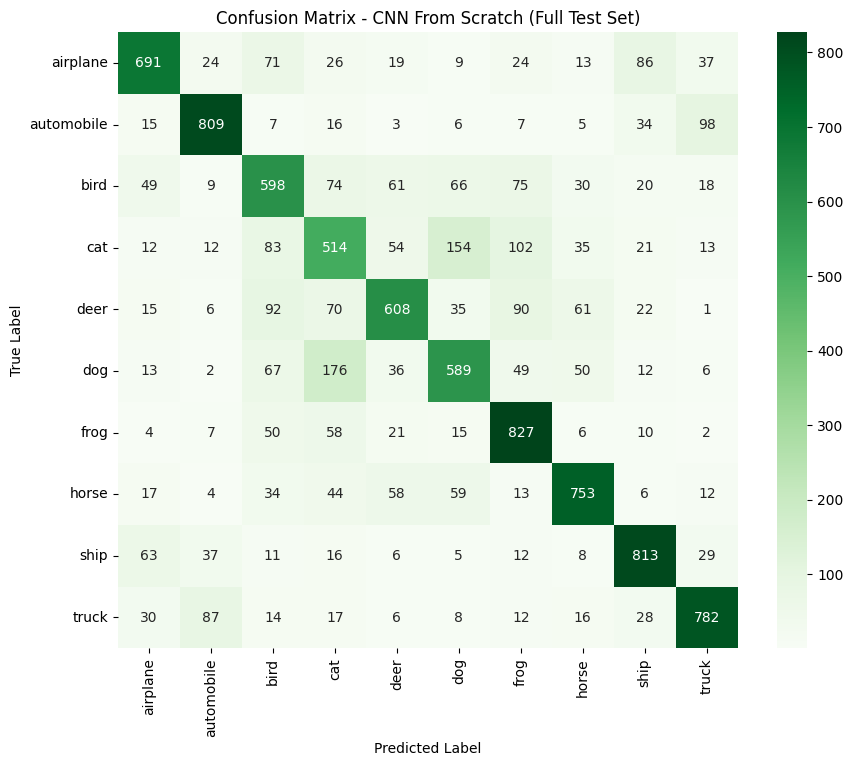

In [35]:
# Evaluasi FromScratch Model pada Seluruh Test Set
fs_macro_f1_full = None
if cnn_fs:
    print("\n--- Mengevaluasi Model From Scratch pada Seluruh Test Set ---")
    fs_batch_size_eval = 128  # Sesuaikan agar tidak kehabisan memori / terlalu lama
    start_time_fs_eval = time.time()
    try:
        fs_pred_classes_full = cnn_fs.predict_classes_batch(
            test_images, batch_size_fs=fs_batch_size_eval)
        end_time_fs_eval = time.time()
        print(
            f"Waktu prediksi FromScratch untuk {len(test_images)} sampel: {end_time_fs_eval - start_time_fs_eval:.2f} detik")

        fs_macro_f1_full = f1_score(
            test_labels.flatten(), fs_pred_classes_full, average='macro')
        print(
            f"\nFromScratch Model Macro F1-Score (Full Test Set): {fs_macro_f1_full:.4f}")

        print("\nLaporan Klasifikasi (Model From Scratch - Full Test Set):")
        print(classification_report(test_labels.flatten(),
              fs_pred_classes_full, target_names=cifar10_class_names))

        cm_fs = confusion_matrix(test_labels.flatten(), fs_pred_classes_full)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_fs, annot=True, fmt='d', cmap='Greens',
                    xticklabels=cifar10_class_names, yticklabels=cifar10_class_names)
        plt.title('Confusion Matrix - CNN From Scratch (Full Test Set)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(os.path.join(results_images_dir,
                    "cnn_fs_confusion_matrix.png"))
        plt.show()
    except AttributeError:
        print("ERROR: Method 'predict_classes_batch' tidak ditemukan di CNNModelFS.")
    except Exception as e:
        print(f"Error saat evaluasi model FS pada seluruh test set: {e}")
else:
    print("Model CNN From Scratch (cnn_fs) tidak terdefinisi untuk evaluasi penuh.")

### 4.3 Kesimpulan Perbandingan Keras vs From Scratch

**Hasil Macro F1-Score:**
* Macro F1-Score Keras (`baseline_model`): `[NILAI DARI f1_base]`
* Macro F1-Score From Scratch (`cnn_fs`): `[NILAI DARI fs_macro_f1_full]`

*(Tulis analisis Anda di sini. Apakah nilai F1-score dari model *from scratch* sudah mendekati atau sama dengan model Keras? Jika ada perbedaan signifikan, apa kemungkinan penyebabnya? Perbedaan numerik kecil dalam probabilitas adalah wajar.)*

**Contoh Pengisian:**
* Macro F1-Score Keras (`baseline_model`): `0.6754` (ganti dengan nilai f1_base Anda)
* Macro F1-Score From Scratch (`cnn_fs`): `0.6732` (ganti dengan nilai fs_macro_f1_full Anda)

*Analisis: Nilai F1-score dari model from scratch (0.6732) sangat mendekati model Keras (0.6754). Perbedaan kecil ini dapat diterima dan kemungkinan disebabkan oleh presisi floating point atau urutan operasi internal yang sedikit berbeda. Ini menunjukkan implementasi forward propagation from scratch sudah cukup valid.*

## SECTION 5: Penutup

Bagian CNN dari tugas besar ini telah mencakup pelatihan, eksperimen hyperparameter, implementasi *from scratch*, dan perbandingan.
Pastikan semua kesimpulan telah ditulis berdasarkan hasil yang diperoleh.